In [1]:
import psycopg2
import matplotlib.pyplot as plt
import pandas as pd

In [238]:
conn = psycopg2.connect("dbname='reddit_data' user='postgres' host='localhost' password=''")
cur = conn.cursor()

In [243]:
#Get the most popular domains of each news type
cur.execute("""
SELECT count(*), count(CASE WHEN news_type = 'liberal' THEN 1 END), count(CASE WHEN news_type = 'conservative' THEN 1 END), replace(substring(article_url from '.*://([^/]*)'), 'www.', '')
FROM NewsArticles
WHERE created_utc > extract(epoch from now() - interval '1 month')
GROUP BY replace(substring(article_url from '.*://([^/]*)'), 'www.', '')
ORDER BY count(*) DESC
""")
result = cur.fetchall()
df = pd.DataFrame(result, columns=["total_count", "liberal_count", "conservative_count", "domain"])

In [153]:
df.head()

,total_count,liberal_count,conservative_count,domain
0,80,78,2,independent.co.uk
1,76,74,2,businessinsider.com
2,70,56,14,thehill.com
3,65,3,62,foxnews.com
4,48,48,0,cnn.com


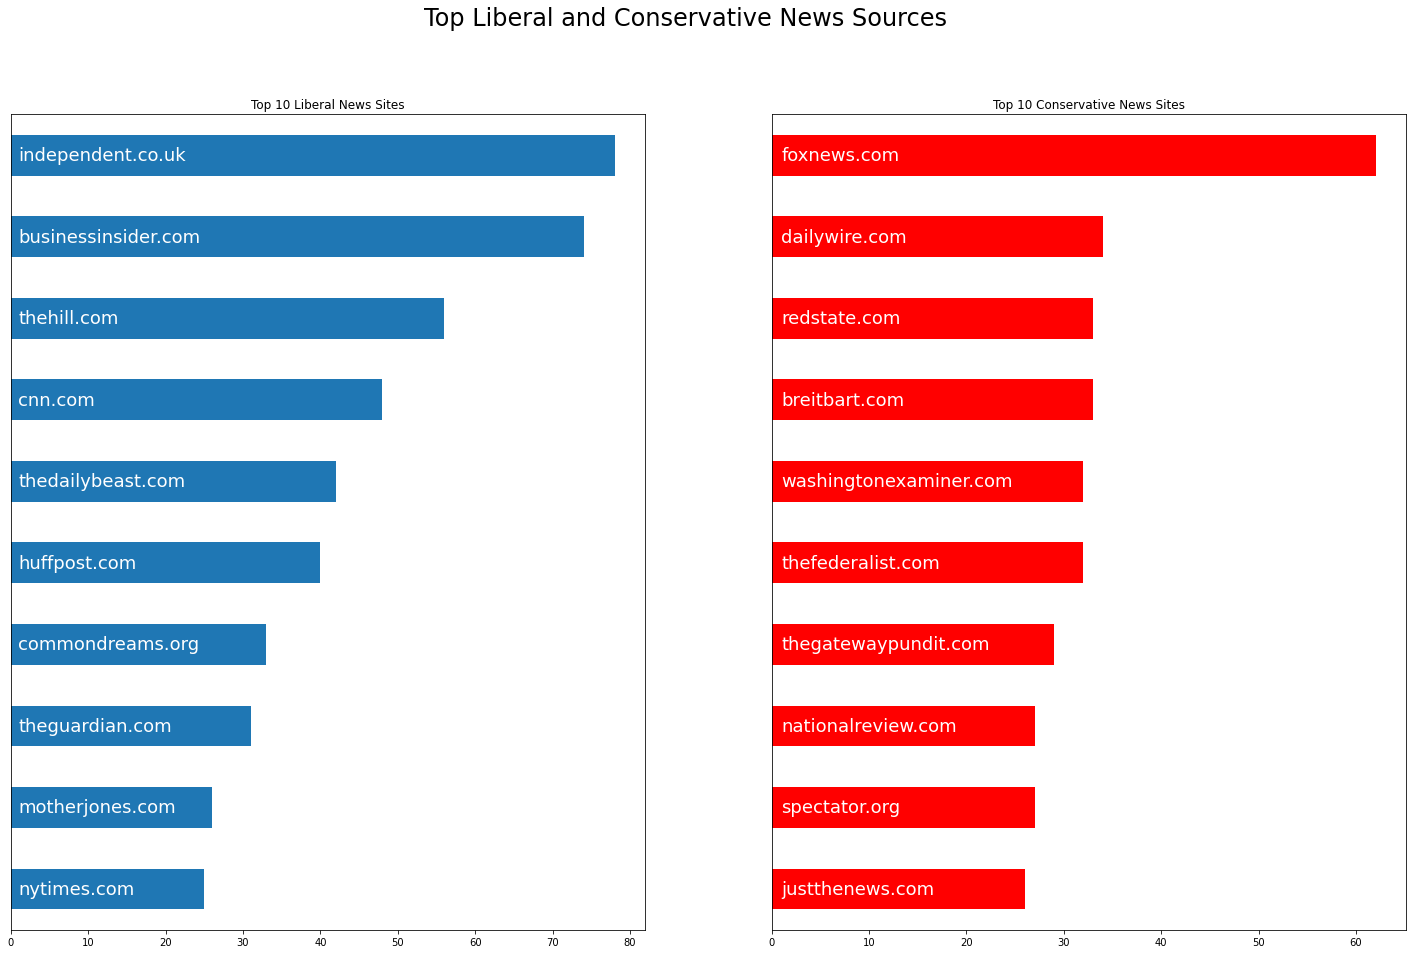

In [218]:
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=2)

df.sort_values('liberal_count', ascending=True)[-10:].plot.barh(ax=axes[0], y=['liberal_count'], x='domain', title="Top 10 Liberal News Sites", rot=45, legend=False, figsize=(25,15)).yaxis.label.set_visible(False)
axes[0].set_yticks([])
for i, (p, pr) in enumerate(zip(df.sort_values('liberal_count', ascending=True)[-10:].index, df.sort_values('liberal_count', ascending=True)[-10:]["domain"])):
    axes[0].text(s=pr, x=1, y=i, color="w", verticalalignment="center", size=18)

df.sort_values('conservative_count', ascending=True)[-10:].plot.barh(ax=axes[1], y=['conservative_count'], x='domain', rot=45, title="Top 10 Conservative News Sites", legend=False, color='r').yaxis.label.set_visible(False)
axes[1].set_yticks([])
for i, (p, pr) in enumerate(zip(df.sort_values('conservative_count', ascending=True)[-10:].index, df.sort_values('conservative_count', ascending=True)[-10:]["domain"])):
    axes[1].text(s=pr, x=1, y=i, color="w", verticalalignment="center", size=18)

plt.suptitle("Top Liberal and Conservative News Sources", fontsize=24)
plt.savefig("top_news_sites.png")

In [19]:
sum(df[['liberal_count','conservative_count']].min(axis=1)) / df['total_count'].sum()

0.03794972893050764

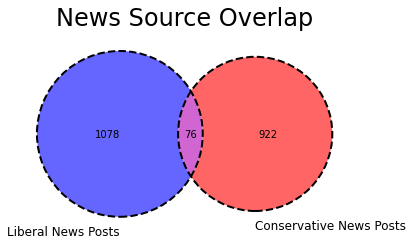

In [244]:
from matplotlib_venn import venn2, venn2_circles
%matplotlib inline
venn2(subsets=(
    df['liberal_count'].sum(), 
    df['conservative_count'].sum(), 
    sum(df[['liberal_count','conservative_count']].min(axis=1))
), set_labels=(
    'Liberal News Posts', 
    'Conservative News Posts'
), set_colors=(
    'blue', 
    'red'
), alpha = 0.6)
venn2_circles(subsets = (
    df['liberal_count'].sum(), 
    df['conservative_count'].sum(), 
    sum(df[['liberal_count','conservative_count']].min(axis=1))
), linestyle='dashed', linewidth=2, color='k');
plt.title('News Source Overlap', fontsize=24);

plt.savefig("news_source_venn_diagram.png")

In [245]:
#Get the most common keywords of each news type
cur.execute("""
SELECT count(*), count(CASE WHEN newsarticles.news_type = 'liberal' THEN 1 END), count(CASE WHEN newsarticles.news_type = 'conservative' THEN 1 END), keyword
FROM articlekeywords
INNER JOIN newsarticles
ON articlekeywords.article_url = newsarticles.article_url
WHERE articlekeywords.created_utc > extract(epoch from now() - interval '1 month')
GROUP BY articlekeywords.keyword
ORDER BY count(*) DESC
""")
result = cur.fetchall()
df = pd.DataFrame(result, columns=["total_count", "liberal_count", "conservative_count", "keyword"])

In [111]:
df.head()

,total_count,liberal_count,conservative_count,keyword
0,575,499,76,trump
1,168,38,130,black
2,101,24,77,matter
3,100,22,78,lives
4,95,62,33,protests


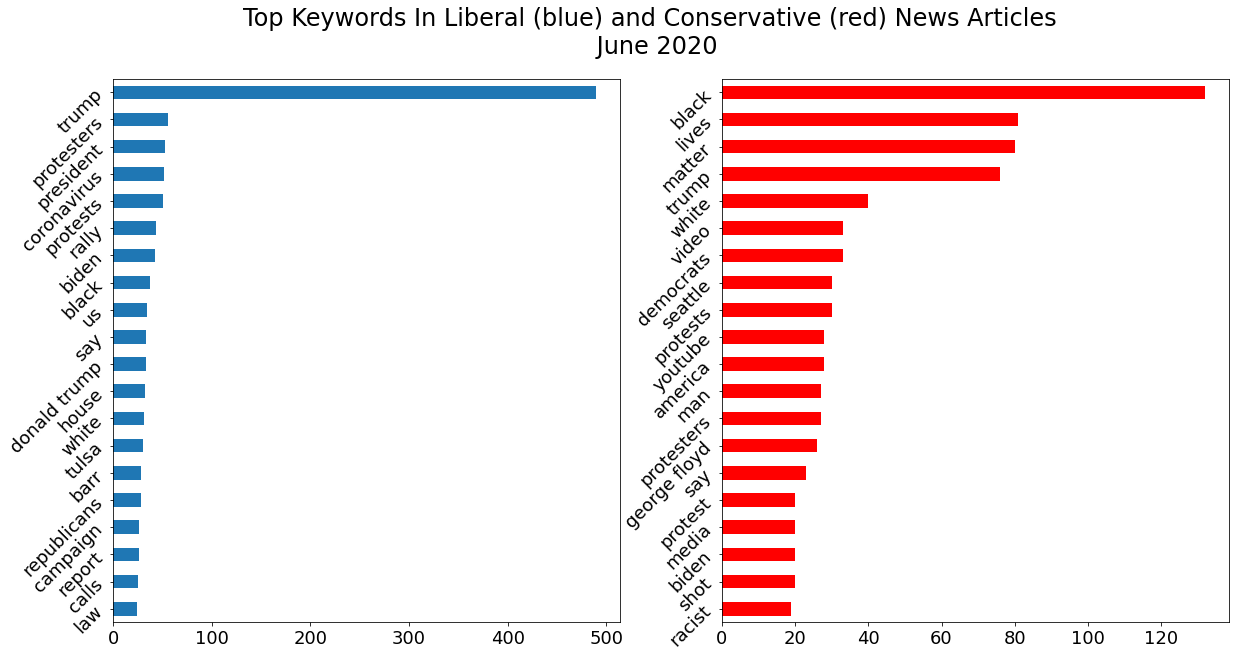

In [247]:
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=2)

df.sort_values('liberal_count', ascending=True)[-20:].plot.barh(ax=axes[0], y=['liberal_count'], x='keyword', rot=45, legend=False, figsize=(20,10), fontsize=18).yaxis.label.set_visible(False)
df.sort_values('conservative_count', ascending=True)[-20:].plot.barh(ax=axes[1], y=['conservative_count'], x='keyword', rot=45, legend=False, color='r', fontsize=18).yaxis.label.set_visible(False)

plt.suptitle("Top Keywords In Liberal (blue) and Conservative (red) News Articles \n June 2020", fontsize=24)
plt.savefig("top_keywords.jpeg")

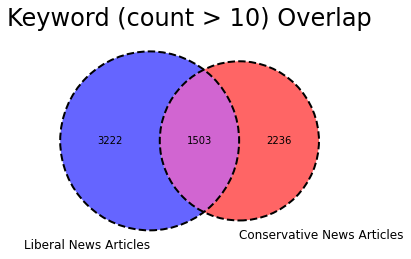

In [235]:
from matplotlib_venn import venn2, venn2_circles

df = df[df['total_count'] > 10]
%matplotlib inline
venn2(subsets=(
    df['liberal_count'].sum(), 
    df['conservative_count'].sum(), 
    sum(df[['liberal_count','conservative_count']].min(axis=1))
), set_labels=(
    'Liberal News Articles', 
    'Conservative News Articles'
), set_colors=(
    'blue', 
    'red'
), alpha = 0.6)
venn2_circles(subsets = (
    df['liberal_count'].sum(), 
    df['conservative_count'].sum(), 
    sum(df[['liberal_count','conservative_count']].min(axis=1))
), linestyle='dashed', linewidth=2, color='k');
plt.title('Keyword (count > 10) Overlap', fontsize=24);

plt.savefig("keyword_venn_diagram.png")

In [222]:
df['liberal_pct'] = df['liberal_count'] / df['total_count']
df['conservative_pct'] = df['conservative_count'] / df['total_count']

df.sort_values(['liberal_pct'], ascending=False)[df['liberal_pct'] < 1.0][:25]

/home/justin/Documents/bifocal-reddit-scraper/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,total_count,liberal_count,conservative_count,domain,liberal_pct,conservative_pct
0,80,78,2,independent.co.uk,0.975000,0.025000
1,76,74,2,businessinsider.com,0.973684,0.026316
17,26,25,1,nytimes.com,0.961538,0.038462
23,22,21,1,nbcnews.com,0.954545,0.045455
37,13,12,1,cnbc.com,0.923077,0.076923
21,25,23,2,axios.com,0.920000,0.080000
8,34,31,3,theguardian.com,0.911765,0.088235
34,13,11,2,reuters.com,0.846154,0.153846
35,13,11,2,usatoday.com,0.846154,0.153846
39,13,11,2,apnews.com,0.846154,0.153846


In [242]:
conn.rollback()